<a href="https://colab.research.google.com/github/varun-kovelamudi/Face-Mask-Detection/blob/main/CNN_evaluations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 28 00:42:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   46C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import os

# Load your models (replace 'model.h5' with the actual path to your model files)
main_model = tf.keras.models.load_model('/content/drive/MyDrive/MaskDetection/best_cnnbasic_model')
pretrained_model = tf.keras.models.load_model('/content/drive/MyDrive/MaskDetection/best_pretrainednn_model')

In [4]:
# Assuming your test data is organized in folders for each class, you can use ImageDataGenerator to load images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    r'/content/drive/MyDrive/test_data',
    target_size=(320, 320), # Or whatever size your model expects
    batch_size=18,
    class_mode='binary',
    shuffle=False) # Important for later mapping predictions back to filenames

# Evaluate models on the test data
main_model_eval = main_model.evaluate(test_generator, verbose=1)
pretrained_model_eval = pretrained_model.evaluate(test_generator, verbose=1)

# If you want predictions for a confusion matrix or other metrics
main_model_predictions = main_model.predict(test_generator, verbose=1)
pretrained_model_predictions = pretrained_model.predict(test_generator, verbose=1)

# To map predictions back to filenames and get the most likely class index
filenames = test_generator.filenames
# Assuming main_model_predictions are the predicted probabilities from your binary classification model
main_model_predicted_classes = (main_model_predictions > 0.5).astype(int)

# Assuming pretrained_model_predictions are the predicted probabilities from another binary classification model
pretrained_model_predicted_classes = (pretrained_model_predictions > 0.5).astype(int)

Found 1912 images belonging to 2 classes.
107/107 [==============================] - 14s 123ms/step


In [5]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[855 120]
 [ 45 892]]


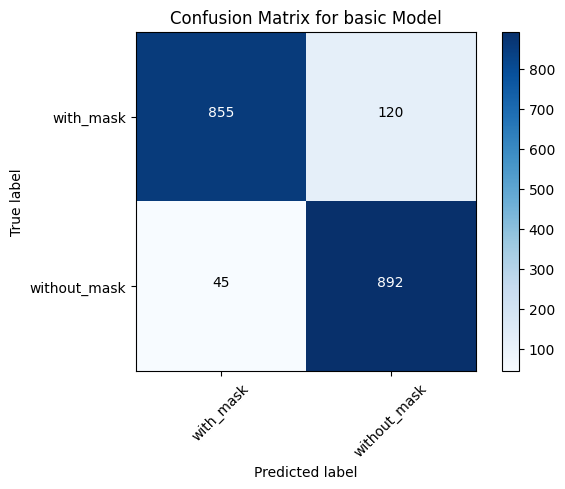

Confusion matrix, without normalization
[[896  79]
 [ 14 923]]


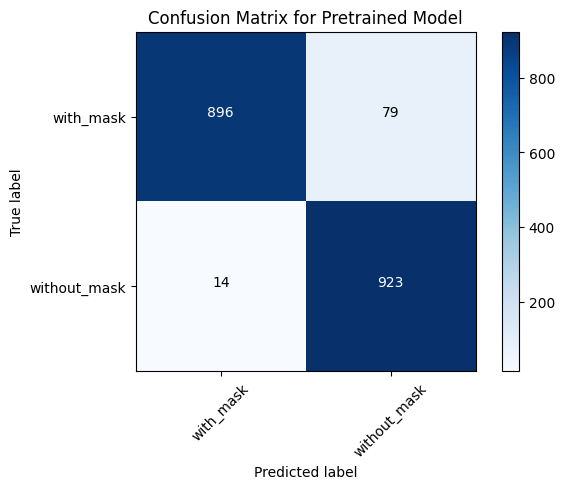

Classification Report for Basic Model:
               precision    recall  f1-score   support

   with_mask       0.95      0.88      0.91       975
without_mask       0.88      0.95      0.92       937

    accuracy                           0.91      1912
   macro avg       0.92      0.91      0.91      1912
weighted avg       0.92      0.91      0.91      1912

Classification Report for Pretrained Model:
               precision    recall  f1-score   support

   with_mask       0.98      0.92      0.95       975
without_mask       0.92      0.99      0.95       937

    accuracy                           0.95      1912
   macro avg       0.95      0.95      0.95      1912
weighted avg       0.95      0.95      0.95      1912



In [6]:
# Assuming you have the predictions and true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix for each model
main_model_cm = confusion_matrix(true_classes, main_model_predicted_classes)
pretrained_model_cm = confusion_matrix(true_classes, pretrained_model_predicted_classes)

# Plot confusion matrix for each model
plt.figure()
plot_confusion_matrix(main_model_cm, classes=class_labels, title='Confusion Matrix for basic Model')
plt.show()

plt.figure()
plot_confusion_matrix(pretrained_model_cm, classes=class_labels, title='Confusion Matrix for Pretrained Model')
plt.show()

# Print classification report for each model
main_model_cr = classification_report(true_classes, main_model_predicted_classes, target_names=class_labels, zero_division=0)
print("Classification Report for Basic Model:\n", main_model_cr)

pretrained_model_cr = classification_report(true_classes, pretrained_model_predicted_classes, target_names=class_labels, zero_division=0)
print("Classification Report for Pretrained Model:\n", pretrained_model_cr)